In [1]:
!pip install tensorflow==2.1

     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 450kB 42.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=7dc01a3ee7c7e8e9b33bf59089be86b5e8c03442fffccccab9db48702181f205
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc1
    Uninstalling tensorflow-2.2.0rc1:
      Successfully uninstalled tensorflow-2.2.0rc1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [18]:
import os

pcm_path = "./pcm_dataset"
wav_path = "./wav_dataset"

# mkdir
if not os.path.exists(pcm_path):
    os.mkdir(pcm_path)

if not os.path.exists(wav_path):
    os.mkdir(wav_path)

# unzip
!unzip "/content/drive/My Drive/ETRI/9_voice_download_4_Korean_English_by_Korean_part2.zip" -d "./pcm_dataset"

print(os.listdir(pcm_path)[:5])
print(len(os.listdir(pcm_path)))

Archive:  /content/drive/My Drive/ETRI/9_voice_download_4_Korean_English_by_Korean_part2.zip
replace ./pcm_dataset/GSF03031LJH0/SW201105KTRNGSF03031LJH0001.pcm? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./pcm_dataset/GSF03031LJH0/SW201105KTRNGSF03031LJH0001.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ['I4F07852PKJ0', 'GSM06235BJH0', 'I4F02224SDY0', 'GSF06654KES0', 'GSF06934SYN0']
50


In [19]:
# pcm to wav

import wave

for i, folder_path in enumerate(os.listdir(pcm_path)):
    file_list = os.listdir(os.path.join(pcm_path, folder_path)) # label's path
    file_list_pcm = [files for files in file_list if files.endswith(".pcm")] # *.pcm files

    for j, file_path in enumerate(file_list_pcm):
        with open(os.path.join(pcm_path, folder_path, file_path), 'rb') as pcm_file:
            pcm_data = pcm_file.read()
        # save as {label}_{features}.wav format
        with wave.open(os.path.join(wav_path, '{}_{}.wav'.format(i, j)), 'wb') as wav_file:
            wav_file.setparams((1, 2, 16000, 0, 'NONE', 'NONE')) # 16kHz, mono channel
            wav_file.writeframes(pcm_data)

# print samples
print(os.listdir(wav_path)[:5])
print(len(os.listdir(wav_path)))

['14_68.wav', '6_39.wav', '7_22.wav', '14_0.wav', '48_67.wav']
5000


In [0]:
# initialized values

num_labels = 50
num_features = 100
sr = 16000
# offset = 3
duration = 1

save_features_name = 'data'
save_labels_name = 'labels'

In [0]:
# save features as *.npz format

import numpy as np
from scipy.io import wavfile

data = np.zeros((num_labels * num_features, duration * sr))
labels = np.zeros((num_labels * num_features))

for i in range(num_labels):
    for j in range(num_features):
        file_name = "{}_{}.wav".format(i, j)
        sample_rate, samples = wavfile.read(os.path.join(wav_path, file_name))
        
        # extract 1 sec (i.e. 'duration * sr' length) of each files
        start = int(len(samples)//2 - duration * sample_rate / 2)
        end = int(len(samples)//2 + duration * sample_rate / 2)
        
        data[i * num_features + j] = samples[start:end]
        labels[i * num_features + j] = i
        
np.save("./" + save_features_name, data)
np.save("./" + save_labels_name, labels)

In [22]:
# load data, labels

from tensorflow.keras.utils import to_categorical

data = np.load(save_features_name + ".npy")
labels = np.load(save_labels_name + ".npy")

print('data.shape: {}, labels.shape: {}'.format(data.shape, labels.shape))

data.shape: (5000, 16000), labels.shape: (5000,)


In [23]:
# split train & test data/labels

from sklearn.model_selection import train_test_split

random_state = 1234
len_data = data.shape[1] # i.e. sr * duration

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size = 0.25, random_state = random_state)

x_train = X_train.reshape(len(X_train), len_data, 1)
x_test = X_test.reshape(len(X_test), len_data, 1) 

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

# standarization
mean = x_train.mean()
x_train -= mean
std = x_train.std()
x_train /= std

x_test -= mean
x_test /= std 

print('x_train.shape: {}, y_train.shape: {}'.format(x_train.shape, y_train.shape))
print('x_test.shape: {}, y_test.shape: {}'.format(x_test.shape, y_test.shape))

x_train.shape: (3750, 16000, 1), y_train.shape: (3750, 50)
x_test.shape: (1250, 16000, 1), y_test.shape: (1250, 50)


In [24]:
# generate model

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(layers.Conv1D(16, 5, activation = 'relu', input_shape = (sr * duration, 1)))
model.add(layers.MaxPooling1D(5))

model.add(layers.Conv1D(32, 7, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(5))

model.add(layers.Conv1D(64, 7, activation = 'relu'))
model.add(layers.MaxPooling1D(5))

model.add(layers.Conv1D(128, 7, activation = 'relu'))
model.add(layers.Conv1D(128, 8, activation = 'relu'))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(num_labels, activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 15996, 16)         96        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 3199, 16)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 3193, 32)          3616      
_________________________________________________________________
batch_normalization_2 (Batch (None, 3193, 32)          128       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 638, 32)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 632, 64)           14400     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 126, 64)          

In [10]:
from datetime import datetime

batch_size = 80
epochs = 50

history = model.fit(x_train, y_train,
                    validation_data = (x_test, y_test),
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1)

save_model_path = "/content/drive/My Drive/models"
if not os.path.exists(save_model_path):
    os.mkdir(save_model_path)

model.save(os.path.join(save_model_path,
                        "Conv1D_{}_{}_{}.h5".format(batch_size, epochs, datetime.today().strftime("%Y_%m_%d"))))

Train on 3750 samples, validate on 1250 samples
Epoch 1/50
3750/3750 [==============================] - 12s 3ms/sample - loss: 4.4044 - accuracy: 0.1016 - val_loss: 5.3269 - val_accuracy: 0.0160
Epoch 2/50
3750/3750 [==============================] - 2s 554us/sample - loss: 2.2001 - accuracy: 0.3469 - val_loss: 9.4278 - val_accuracy: 0.0160
Epoch 3/50
3750/3750 [==============================] - 2s 552us/sample - loss: 1.4228 - accuracy: 0.5541 - val_loss: 12.7898 - val_accuracy: 0.0208
Epoch 4/50
3750/3750 [==============================] - 2s 555us/sample - loss: 0.9318 - accuracy: 0.6971 - val_loss: 11.6621 - val_accuracy: 0.0640
Epoch 5/50
3750/3750 [==============================] - 2s 553us/sample - loss: 0.7068 - accuracy: 0.7723 - val_loss: 14.2049 - val_accuracy: 0.0592
Epoch 6/50
3750/3750 [==============================] - 2s 546us/sample - loss: 0.5171 - accuracy: 0.8403 - val_loss: 13.6236 - val_accuracy: 0.0584
Epoch 7/50
3750/3750 [==============================] - 2s 54

In [11]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

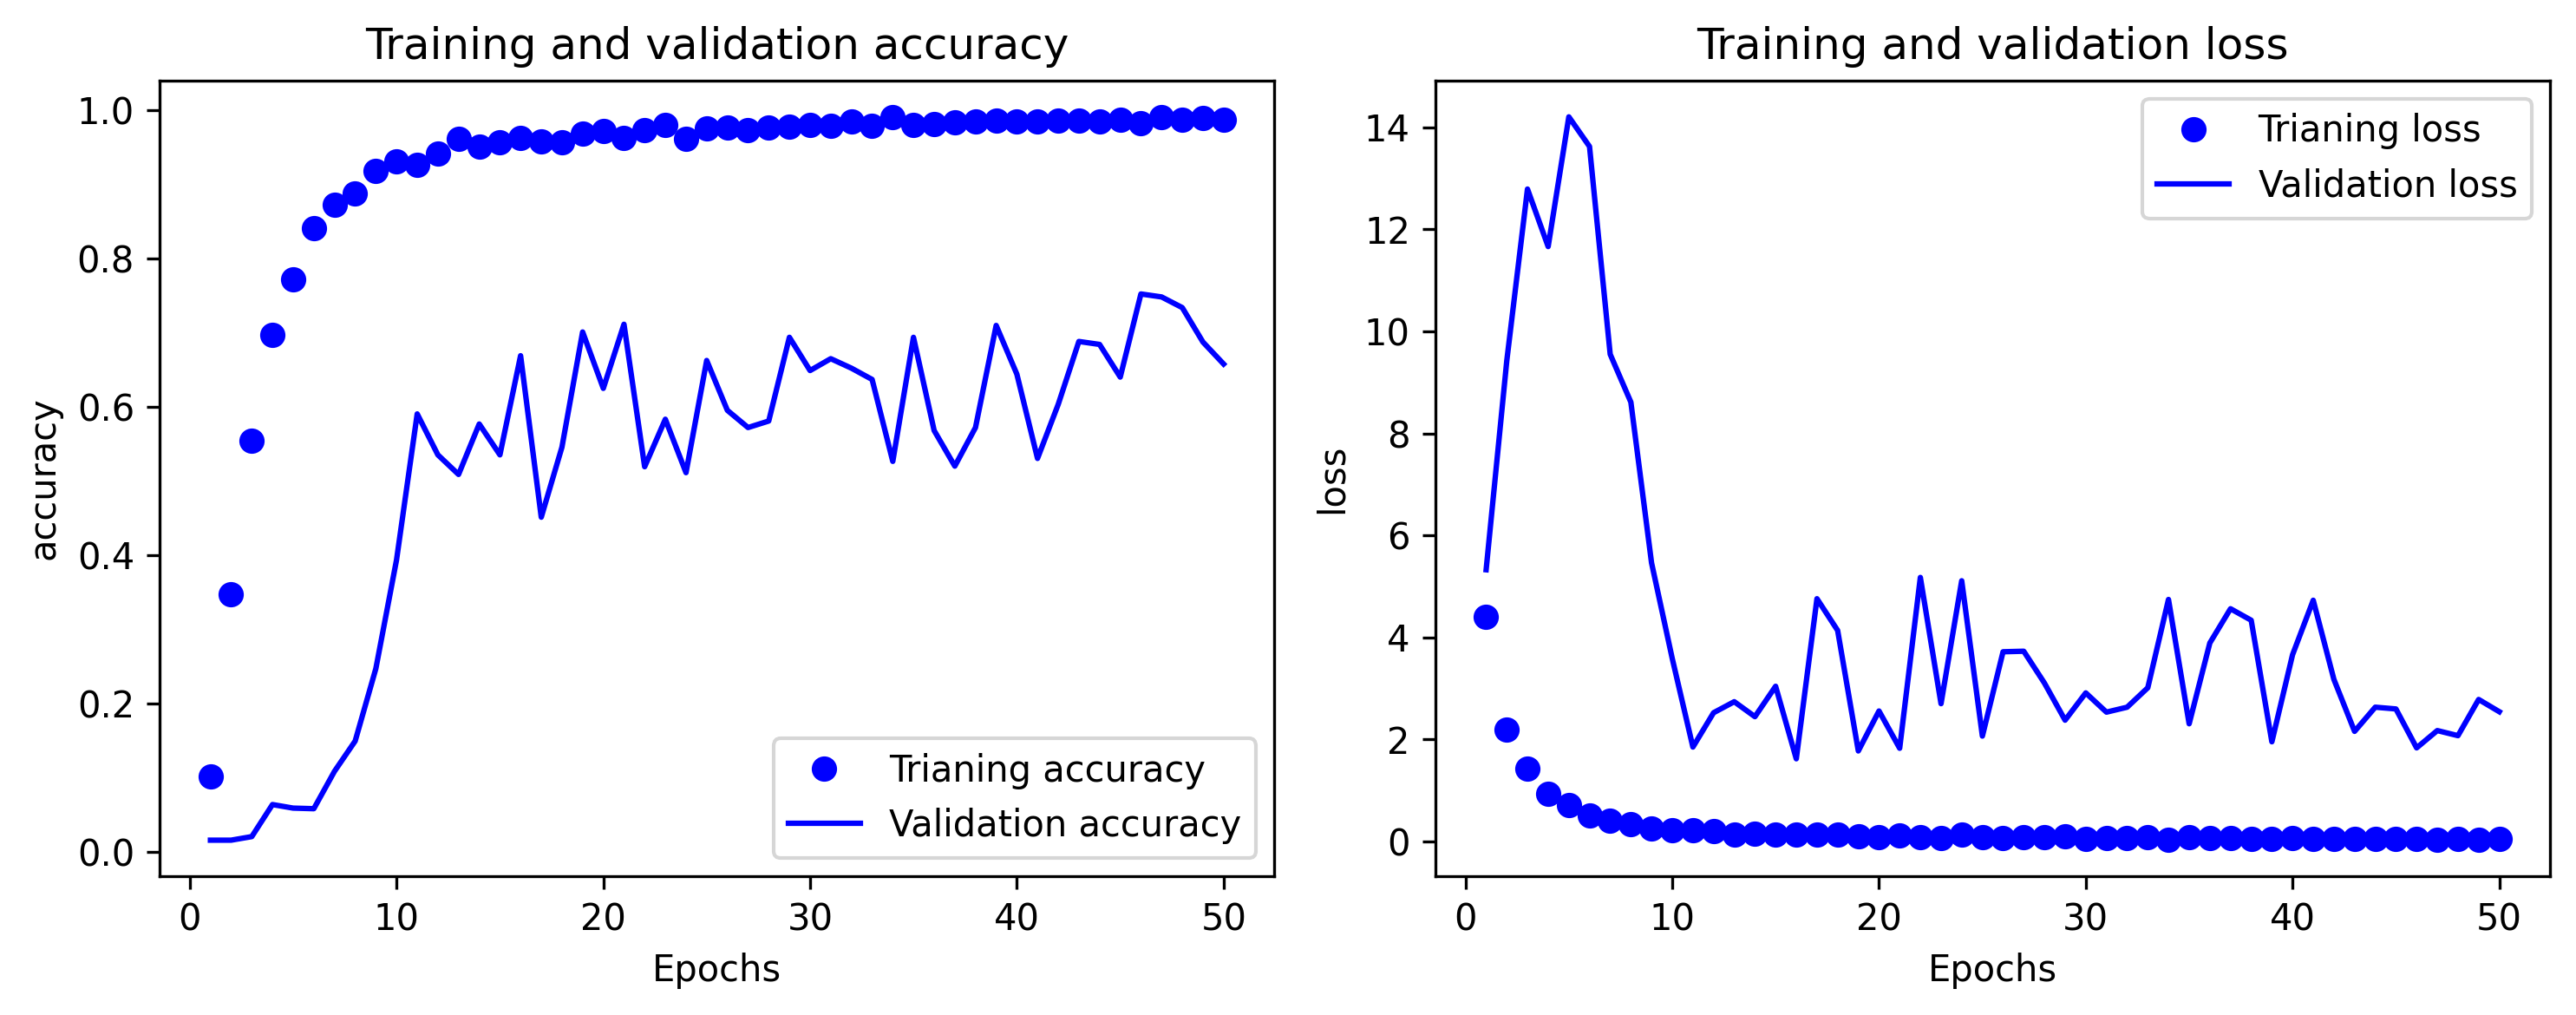

In [17]:
# plot

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

fig = plt.figure(figsize = (10, 4), facecolor = 'white', dpi = 300)

# accuracy
plt.subplot(1, 2, 1)

plt.plot(range(1, epochs + 1), acc, 'bo', label = 'Trianing accuracy')
plt.plot(range(1, epochs + 1), val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)

plt.plot(range(1, epochs + 1), loss, 'bo', label = 'Trianing loss')
plt.plot(range(1, epochs + 1), val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()